# Queston 01

In [ ]:
# Imports
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load the image in grayscale
img = Image.open('emma.jpg').convert("L")
input_pixels = np.array(img)

In [ ]:
transformed_pixels = np.zeros_like(input_pixels, dtype=np.uint8)

In [ ]:
# Input intensity between 0 and 49
mask_low_range = input_pixels < 50
transformed_pixels[mask_low_range] = input_pixels[mask_low_range]

In [ ]:
# Input intensity between 50 and 149
mask_mid_range = (input_pixels >= 50) & (input_pixels < 150)
transformed_pixels[mask_mid_range] = (
    100 + (input_pixels[mask_mid_range] - 50) * (155 // 100)
)

In [ ]:
# Input intensity between 150 and 255
mask_high_range = input_pixels >= 150
transformed_pixels[mask_high_range] = input_pixels[mask_high_range]

In [ ]:
transformed_image = Image.fromarray(transformed_pixels)

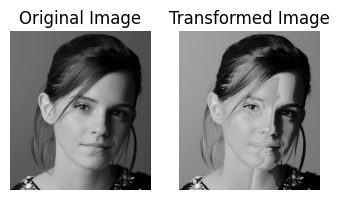

In [ ]:
# Display original and transformed images side by side
plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.imshow(input_pixels, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(transformed_pixels, cmap="gray")
plt.title("Transformed Image")
plt.axis("off")

plt.show()

# Question 02

In [ ]:
# Imports
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Helper functions

def estimate_non_background_percentiles(image_uint8, background_limit=5):
    all_pixels = image_uint8.ravel()
    non_background = all_pixels[all_pixels > background_limit]
    return np.percentile(non_background, [10, 35, 50, 60, 80, 90])

# Building window lookup table
def build_window_lut(window_start, window_end,
                     output_min=0, output_max=255,
                     outside_slope_fraction=0.05):
    x = np.arange(256, dtype=np.float32)
    inside_slope = (output_max - output_min) / max(window_end - window_start, 1e-6)
    outside_slope = outside_slope_fraction * inside_slope

    lut = np.zeros_like(x)
    below = x < window_start
    inside = (x >= window_start) & (x <= window_end)
    above = x > window_end

    lut[below]  = output_min + outside_slope * (x[below] - window_start)
    lut[inside] = output_min + inside_slope   * (x[inside] - window_start)
    lut[above]  = output_max + outside_slope * (x[above] - window_end)

    return np.clip(lut, 0, 255).astype(np.uint8)

# Applying Lookup table
def apply_lookup_table(image_uint8, lut):
    return lut[image_uint8]

In [ ]:
# Loading the image
image_path = "brain_proton_density_slice.png"
brain_image = Image.open(image_path).convert("L")
brain_pixels = np.array(brain_image)

# Estimate intensity ranges
p10, p35, p50, p60, p80, p90 = estimate_non_background_percentiles(brain_pixels)

# White matter = darker band, Gray matter = brighter band
white_matter_window = (int(p35), int(p60))
gray_matter_window  = (int(p60), int(p80))

# Build transforms
white_matter_lut = build_window_lut(*white_matter_window)
gray_matter_lut  = build_window_lut(*gray_matter_window)

# Apply transforms
white_matter_enhanced = apply_lookup_table(brain_pixels, white_matter_lut)
gray_matter_enhanced  = apply_lookup_table(brain_pixels, gray_matter_lut)

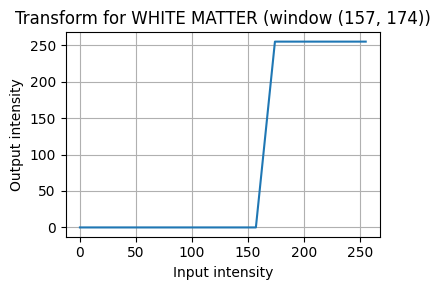

In [ ]:
# transform curve for WHITE MATTER
x = np.arange(256)
plt.figure(figsize=(4,3))
plt.plot(x, white_matter_lut)
plt.title(f"Transform for WHITE MATTER (window {white_matter_window})")
plt.xlabel("Input intensity"); plt.ylabel("Output intensity"); plt.grid(True)
plt.tight_layout(); plt.show()

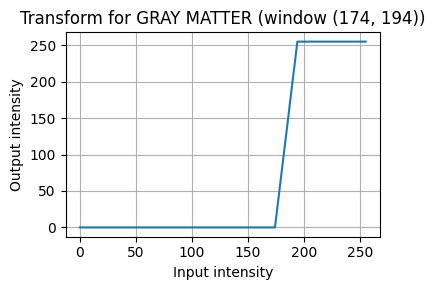

In [ ]:
# transform curve for GRAY MATTER
plt.figure(figsize=(4,3))
plt.plot(x, gray_matter_lut)
plt.title(f"Transform for GRAY MATTER (window {gray_matter_window})")
plt.xlabel("Input intensity"); plt.ylabel("Output intensity"); plt.grid(True)
plt.tight_layout(); plt.show()

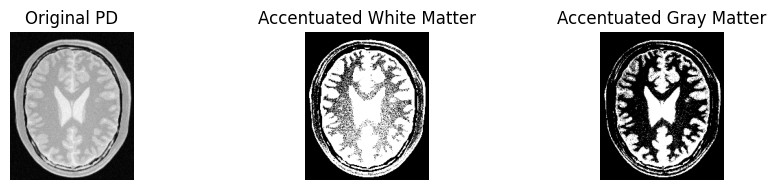

In [ ]:
# Show the transformed images

plt.figure(figsize=(10,2))
plt.subplot(1,3,1); plt.imshow(brain_pixels, cmap="gray"); plt.title("Original PD"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(white_matter_enhanced, cmap="gray"); plt.title("Accentuated White Matter"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(gray_matter_enhanced,  cmap="gray"); plt.title("Accentuated Gray Matter");  plt.axis("off")
plt.tight_layout(); plt.show()

# Question 03

In [ ]:
# Installing opencv

!pip install opencv-python

In [ ]:
# Imports

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Configuration

input_image_path  = "highlights_and_shadows.jpg"
output_image_path = "image_L_gamma_0p8.jpg"
gamma_value = 1.0

In [ ]:
# Load image (BGR in OpenCV)

bgr_image = cv2.imread(input_image_path)
if bgr_image is None:
    raise FileNotFoundError(f"Could not read {input_image_path}")

In [ ]:
# BGR → LAB (OpenCV: L 0–255; a/b centered at 128)

lab_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2LAB)
L_channel, a_channel, b_channel = cv2.split(lab_image)  # uint8

In [ ]:
# Apply gamma to L only
L_normalized = L_channel.astype(np.float32) / 255.0         # [0,1]
L_gamma_corrected = (L_normalized ** gamma_value) * 255.0   # back to [0,255]
L_gamma_u8 = np.clip(L_gamma_corrected, 0, 255).astype(np.uint8)

In [ ]:
# Reassemble LAB and convert back to BGR
lab_corrected = cv2.merge([L_gamma_u8, a_channel, b_channel])
bgr_corrected = cv2.cvtColor(lab_corrected, cv2.COLOR_LAB2BGR)

In [ ]:
# Save gamma corrected image

cv2.imwrite(output_image_path, bgr_corrected)

True

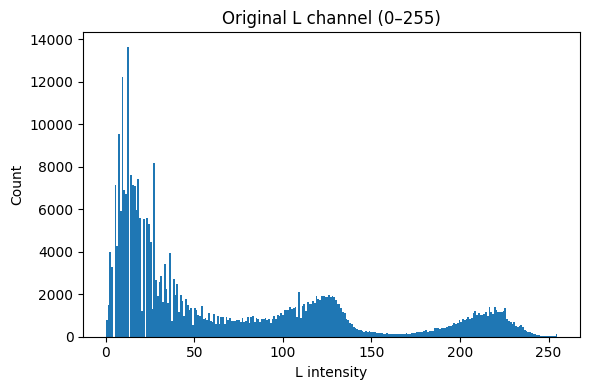

In [ ]:
# Histogram for Original

plt.figure(figsize=(6,4))
plt.hist(L_channel.ravel(), bins=256, range=(0,255))
plt.title("Original L channel (0–255)")
plt.xlabel("L intensity"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

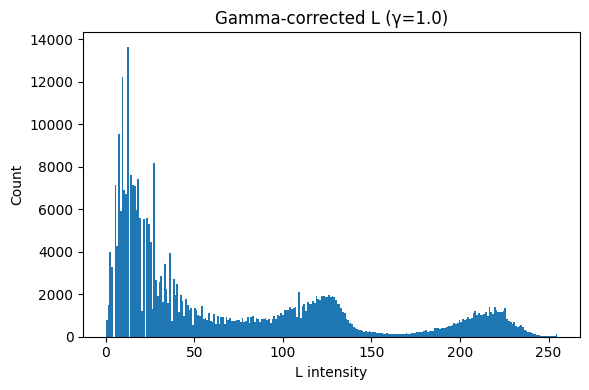

In [ ]:
# Histogram for corrected

plt.figure(figsize=(6,4))
plt.hist(L_gamma_u8.ravel(), bins=256, range=(0,255))
plt.title(f"Gamma-corrected L (γ={gamma_value})")
plt.xlabel("L intensity"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

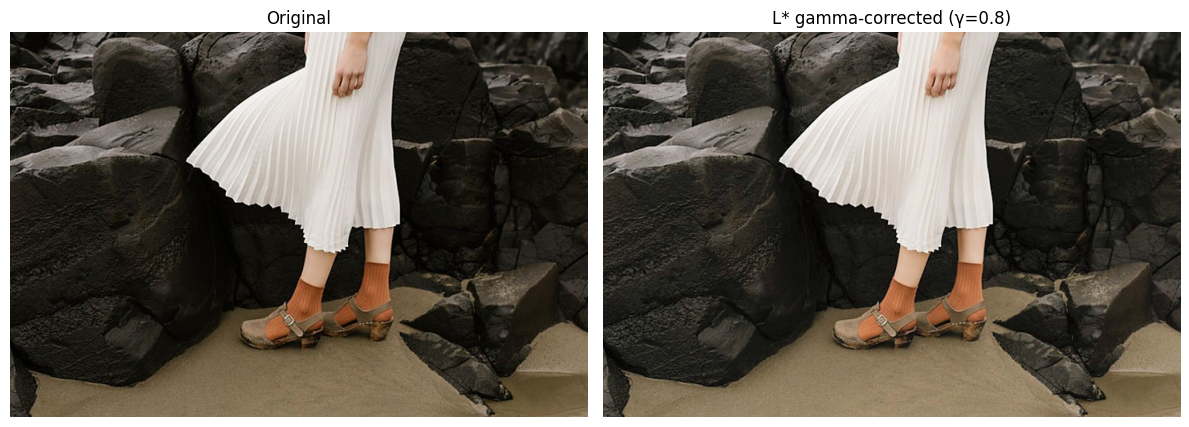

In [ ]:
# Plot Original and Corrected side by side

rgb_original  = cv2.cvtColor(bgr_image,     cv2.COLOR_BGR2RGB)
rgb_corrected = cv2.cvtColor(bgr_corrected, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(rgb_original)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(rgb_corrected);
plt.title(f"L* gamma-corrected (γ={gamma_value})")
plt.axis("off")
plt.tight_layout()
plt.show()

# Question 04

In [61]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [62]:
# Image config
image_path = "spider.png"
output_image = "spider_vibrance_enhanced.png"
vibrance_strength  = 0.65
gaussian_sigma = 70.0

In [63]:
bgr_image = cv2.imread(image_path)
if bgr_image is None:
    raise FileNotFoundError(f"Could not read {image_path}")

# HSV ranges: H ∈ [0,179], S ∈ [0,255], V ∈ [0,255]
hsv_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)

# (a) Split the image into H, S, V planes
hue_channel, saturation_channel, value_channel = cv2.split(hsv_image)  # each is uint8

In [64]:
# Applying vibrance transform to Saturation only
saturation_float = saturation_channel.astype(np.float32)

# Gaussian “bump” centered at 128 (mid-saturation)
gaussian_bump = 128.0 * np.exp(-((saturation_float - 128.0) ** 2) / (2.0 * gaussian_sigma * gaussian_sigma))

# Apply the intensity transform ONLY to the Saturation plane
# f(x) = min( x + a * bump, 255 )
saturation_enhanced = np.clip(
    saturation_float + vibrance_strength * gaussian_bump,
    0, 255
).astype(np.uint8)


In [65]:
# Recombine channels and convert back to BGR
hsv_enhanced = cv2.merge([hue_channel, saturation_enhanced, value_channel])
bgr_enhanced = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2BGR)

# Save result
cv2.imwrite(output_image, bgr_enhanced)

# Adjust 'a' for pleasing output and REPORT it
print(f"[REPORT] Chosen vibrance strength a = {vibrance_strength}")

[REPORT] Chosen vibrance strength a = 0.65


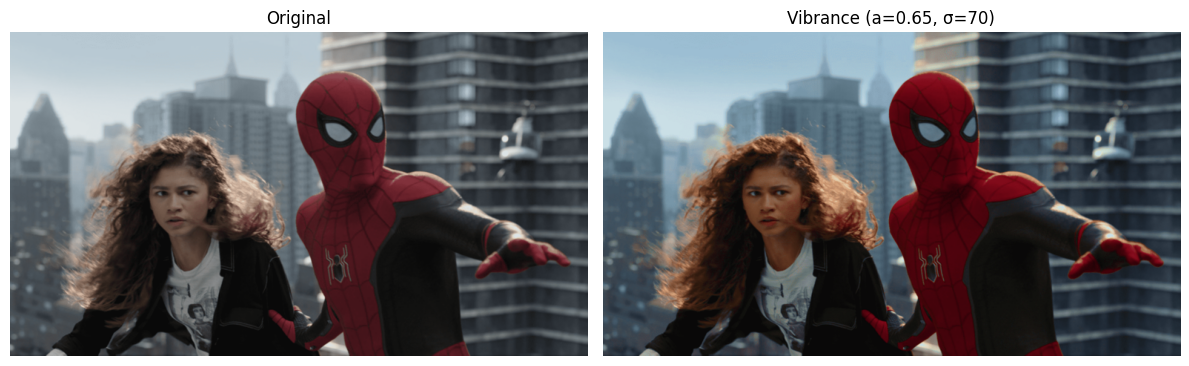

In [66]:
# Display the original image and the vibrance-enhanced image
rgb_original  = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
rgb_enhanced  = cv2.cvtColor(bgr_enhanced, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb_original)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(rgb_enhanced);
plt.title(f"Vibrance (a={vibrance_strength}, σ={int(gaussian_sigma)})");
plt.axis("off")
plt.tight_layout()
plt.show()

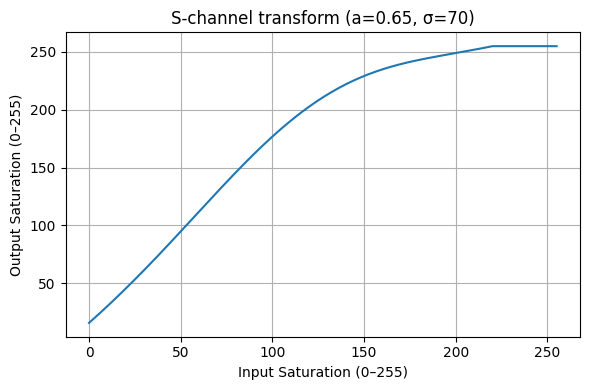

In [70]:
# Display the intensity transformation curve f(x) used on the S channel
input_s_values = np.arange(256, dtype=np.float32)
bump_curve     = 128.0 * np.exp(-((input_s_values - 128.0) ** 2) / (2.0 * gaussian_sigma * gaussian_sigma))
output_s_values = np.minimum(input_s_values + vibrance_strength * bump_curve, 255.0)

plt.figure(figsize=(6, 4))
plt.plot(input_s_values, output_s_values)
plt.title(f"S-channel transform (a={vibrance_strength}, σ={int(gaussian_sigma)})")
plt.xlabel("Input Saturation (0–255)")
plt.ylabel("Output Saturation (0–255)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Question 05

In [71]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [72]:
# Image Config
image_path = "jeniffer.jpg"
output_image = "jenniffer_foreground_hist_e.jpg"

In [124]:
# Load Image
bgr_image = cv2.imread(image_path)
if bgr_image is None:
    raise FileNotFoundError(f"Cannot read image {image_path}")

# (a) Split the image to HSV
# HSV ranges: H ∈ [0,179], S ∈ [0,255], V ∈ [0,255]
hsv_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)
hue_plane, saturation_plane, value_plane = cv2.split(hsv_image)

In [125]:
# (b) Foreground mask
# Otsu on Saturation: subject typically has higher S than background
otsu_threshold_value, foreground_mask = cv2.threshold(
    saturation_plane, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
foreground_mask = cv2.morphologyEx(foreground_mask, cv2.MORPH_CLOSE, kernel, 1)
foreground_mask = cv2.morphologyEx(foreground_mask, cv2.MORPH_OPEN,  kernel, 1)

In [126]:
# (c) Foreground histogram
# Compute histogram of Value channel ONLY where mask==255
foreground_hist_counts = cv2.calcHist(
    images=[value_plane], channels=[0], mask=foreground_mask, histSize=[256], ranges=[0, 256]
).flatten().astype(np.int64)

In [127]:
# (d, e) CDF → LUT
foreground_cdf = np.cumsum(foreground_hist_counts).astype(np.float64)
if foreground_cdf[-1] > 0:
    cdf_min = foreground_cdf[foreground_cdf > 0][0]
    lut = np.floor((foreground_cdf - cdf_min) * 255.0 / (foreground_cdf[-1] - cdf_min + 1e-9))
else:
    lut = np.zeros(256)
lookup_table = np.clip(lut, 0, 255).astype(np.uint8)

In [128]:
# Equalize foreground ONLY on Value plane
equalized_value_plane = value_plane.copy()
equalized_value_plane[foreground_mask == 255] = lookup_table[value_plane[foreground_mask == 255]]

In [129]:
# (f) Recombine & save
hsv_equalized = cv2.merge([hue_plane, saturation_plane, equalized_value_plane])
bgr_result = cv2.cvtColor(hsv_equalized, cv2.COLOR_HSV2BGR)

# Save Result Image
cv2.imwrite(output_image, bgr_result)

True

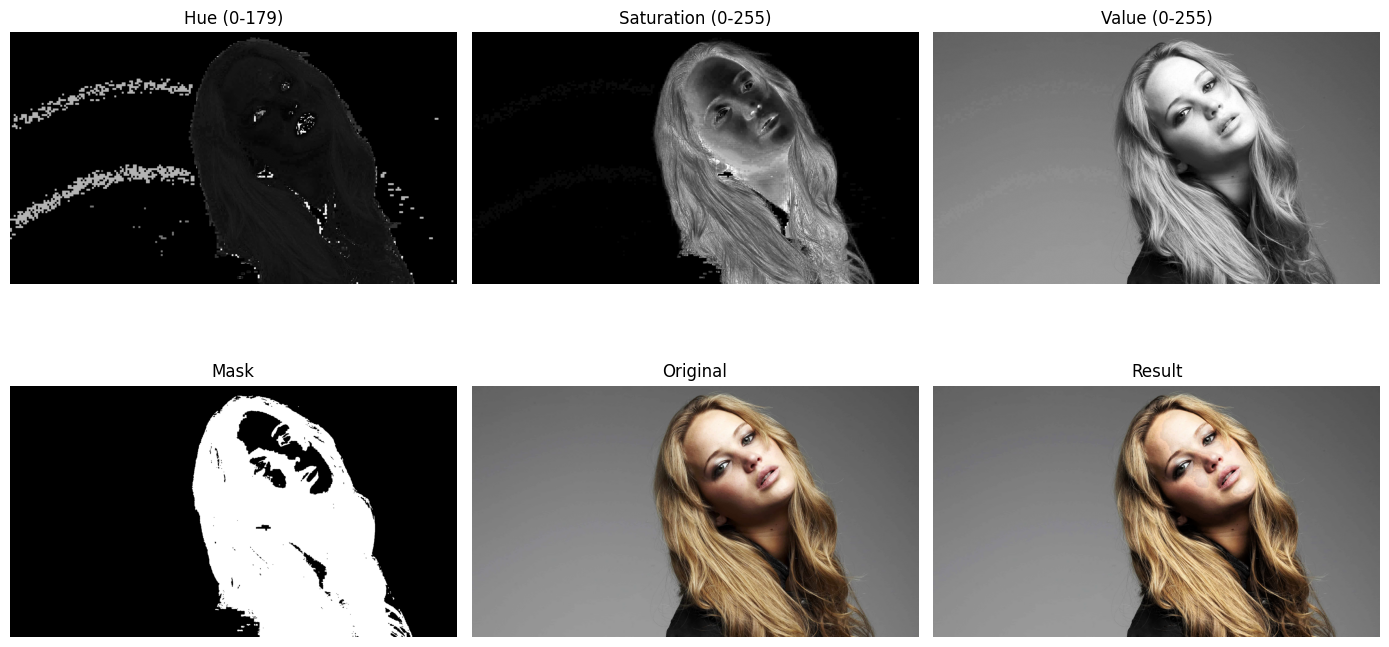

In [130]:
# Visualize Results
rgb_original = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
rgb_result   = cv2.cvtColor(bgr_result, cv2.COLOR_BGR2RGB)

# Display Hue, Saturation, and Value
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes[0,0].imshow(hue_plane, cmap="gray");
axes[0,0].set_title("Hue (0-179)");
axes[0,0].axis("off")

axes[0,1].imshow(saturation_plane, cmap="gray");
axes[0,1].set_title("Saturation (0-255)");
axes[0,1].axis("off")

axes[0,2].imshow(value_plane, cmap="gray");
axes[0,2].set_title("Value (0-255)");
axes[0,2].axis("off")

# Display Mask, Original image, Result Image
# Result - Foreground histogram-equalized
axes[1,0].imshow(foreground_mask, cmap="gray");
axes[1,0].set_title("Mask");
axes[1,0].axis("off")

axes[1,1].imshow(rgb_original);
axes[1,1].set_title("Original");
axes[1,1].axis("off")

axes[1,2].imshow(rgb_result);
axes[1,2].set_title("Result");
axes[1,2].axis("off")
plt.tight_layout();
plt.show()

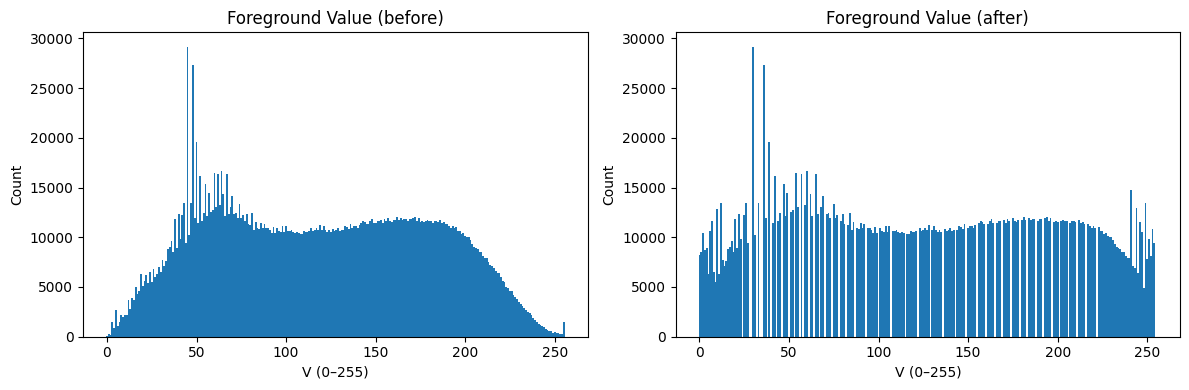

In [121]:
# Display Histograms (before vs after on foreground)
foreground_values_after = equalized_value_plane[foreground_mask == 255]
foreground_hist_counts_after = cv2.calcHist(
    images = [equalized_value_plane], channels=[0],
    mask = foreground_mask, histSize=[256], ranges=[0, 256]
).flatten()

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.bar(np.arange(256), foreground_hist_counts, width=1)
ax1.set_title("Foreground Value (before)")
ax2.bar(np.arange(256), foreground_hist_counts_after, width=1);
ax2.set_title("Foreground Value (after)")
for ax in (ax1, ax2):
    ax.set_xlabel("V (0–255)");
    ax.set_ylabel("Count")
plt.tight_layout();
plt.show()